# Network Algorithms Homework
By Asif Mammadov, Rustam Aliyev, Maryam Babayeva

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from geopy import distance
from geopy import Point
import utils
import shortest_path
import create_map

# Processing the data

In [2]:
# Obtain the data
airports = pd.read_csv('airports.csv')
routes = pd.read_csv('routes.csv')

airports.head(5)

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


## Filter N/A values

In [3]:
# returns all the information about an airport by its IATA
def airport_info(data_airports, iata):
    return data_airports.loc[data_airports['IATA'] == iata]
# returns all the name of the airport by its IATA
def airport_name_from_iata(data_airports, iata):
    return data_airports.loc[data_airports['IATA'] == iata]['Name'].iat[0]

In [4]:
# returns filtered 'df' from N/A values in the column 'column'
def filter_na(df, column):
    na_rows = df[column].str.len() < 3
    return df[~na_rows]

# Filter the N/A values in the data
filtered_airports = filter_na(airports, "IATA")
filtered_routes = filter_na(routes, 'Source airport ID')
filtered_routes = filter_na(filtered_routes, 'Destination airport ID')

In [5]:
# change the datatype in routes
filtered_routes['Source airport ID'] = filtered_routes['Source airport ID'].astype('int64')
filtered_routes['Destination airport ID'] = filtered_routes['Destination airport ID'].astype('int64')

## Filter by Region/Countries

In [6]:
# returns the array of countries representing the region if supported, otherwise None
def get_countries_of(region):
    import requests
    supported_regions = ['europe', 'asia', 'africa']
    countries = []
    if region in supported_regions:
        response = requests.get("https://restcountries.com/v3.1/region/" + region)
        l = response.json()
        for i in range(len(l)):
            countries.append(l[i]['name']['common'])
        return countries
    return None

# returns new filtered dataframe to specified region
def filter_to_region(df, region):
    europe = get_countries_of(region)
    return df[df['Country'].isin(europe)]

# returns new filtered dataframe to specified countries 
def filter_to_countries(df, countries):
    return df[df['Country'].isin(countries)]

# Choose only one region (europe in our example)
# This data for demonstration purpose only. We can't use it due to computational limitations
filtered_european_airports = filter_to_region(filtered_airports, 'europe')

# Choose only one country (France in our example)
# we chose only one country due to computational limitations
filtered_regional_airports = filter_to_countries(filtered_airports, ['France'])

In [7]:
# Filter routes according to filtered airports
airport_id = filtered_regional_airports['Airport ID']
filtered_regional_routes = filtered_routes[filtered_routes['Source airport ID'].isin(airport_id) & filtered_routes['Destination airport ID'].isin(airport_id)]

In [8]:
# Interactive map to view filtered airports (optional)
create_map.create_map(filtered_regional_airports, 'filtered_airports.html')

## Adding airport coordinates to routes

In [9]:
# returns the coordinates (latitude, longitude) of an airport by its id from 'airports' dataframe
def get_coords(airport_id, airports):
    airport = airports.loc[airports['Airport ID'] == airport_id]
    return (airport['Latitude'], airport['Longitude'])

In [10]:
# Add the coordinates columns for the 'routes' dataframe from 'airports' dataframe
def add_coords_to_routes(routes, airports):
    pd.options.mode.chained_assignment = None
    sources_latitude = []
    sources_longitude = []
    destinations_latitude = []
    destinations_longitude = []

    for ind in routes.index:
        source_coords = get_coords(routes.loc[ind, 'Source airport ID'], airports)
        sources_latitude.append(source_coords[0].to_string().split(' ')[-1])
        sources_longitude.append(source_coords[1].to_string().split(' ')[-1])

        destination_coords = get_coords(routes.loc[ind, 'Destination airport ID'], airports)
        destinations_latitude.append(destination_coords[0].to_string().split(' ')[-1])
        destinations_longitude.append(destination_coords[1].to_string().split(' ')[-1])
    
    routes.loc[:, 'Source latitude'] = sources_latitude
    routes.loc[:, 'Source longitude'] = sources_longitude
    routes.loc[:, 'Destination latitude'] = destinations_latitude
    routes.loc[:, 'Destination longitude'] = destinations_longitude

    return routes

In [11]:
filtered_regional_routes = add_coords_to_routes(filtered_regional_routes, filtered_regional_airports)

## Getting distances

In [12]:
# returns array of distances between routes
def get_dists(routes):
    return routes.apply(
        lambda row:
            distance.distance(
                (row['Source latitude'], row['Source longitude']),
                (row['Destination latitude'], row['Destination longitude'])
            ).km,
        axis = 1
    )

In [13]:
# Getting distance values
dists = get_dists(filtered_regional_routes)
distances_series = pd.Series(dists, name = 'Distance')

# Dataframe with Source, Destination and Distance
data = [filtered_regional_routes['Source airport'].reset_index(drop=True),filtered_regional_routes['Destination airport'].reset_index(drop=True), distances_series.reset_index(drop=True)]
df_routes = pd.DataFrame(data).T

## Converting to graph

In [14]:
#Creating a graph from the filtered regional routes
G = nx.from_pandas_edgelist(df_routes, source='Source airport', target='Destination airport', edge_attr=True, create_using=nx.DiGraph)
# nx.draw_networkx(G, node_size=500, )
# nx.draw(G, with_labels=True)

print("List of airports:\n", sorted(G.nodes()))

List of airports:
 ['AGF', 'AJA', 'ANG', 'AUR', 'AVN', 'BES', 'BIA', 'BIQ', 'BOD', 'BSL', 'BVA', 'BVE', 'BZR', 'CDG', 'CFE', 'CFR', 'CLY', 'DCM', 'DIJ', 'EBU', 'EGC', 'ETZ', 'FSC', 'LAI', 'LDE', 'LEH', 'LIG', 'LIL', 'LPY', 'LRH', 'LRT', 'LYS', 'MPL', 'MRS', 'NCE', 'NTE', 'ORY', 'PGF', 'PGX', 'PIS', 'PUF', 'RDZ', 'RNS', 'SXB', 'TLN', 'TLS', 'TUF', 'UIP']


In [15]:
def draw(G, pos, measures, measure_name):
    nodes = nx.draw_networkx_nodes(G, pos, node_size=400, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos)
    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()
pos = nx.spring_layout(G, k=1.5, dim=2)


In [16]:
# Network Density
network_densit = utils.network_density(G)
print("Network Density = ", network_densit)

Network Density =  0.2765957446808511


The graph with 27.6% density is considered sparse. However, we think that for the airports network it is quite connected. 

In [17]:
# Network Diameter
m_path = utils.max_path(utils.get_all_pathes(G, 'Distance'))
network_diam = utils.network_diameter(G, 'Distance')
print("Network Diameter = %d\nMax path : %s" % (network_diam, m_path))
# Translate to the airport names
for iata in m_path:
    print(airport_name_from_iata(filtered_regional_airports, iata), end=" ")

Network Diameter = 6
Max path : ['AGF', 'DCM', 'AJA', 'NCE', 'BIA', 'EBU']
Agen-La Garenne Airport Castres-Mazamet Airport Ajaccio-Napoléon Bonaparte Airport Nice-Côte d'Azur Airport Bastia-Poretta Airport Saint-Étienne-Bouthéon Airport 

In [18]:
# Network Average Path Length
napl = utils.network_average_path_length(G, 'Distance')
print("Network Average Path Length = %.2f" % napl)

Network Average Path Length = 3.19


The Network Diameter is almost 2 times bigger than the Averge Path Length.

In [19]:
#Closeness Centrality of Airport
closeness_c = {}
for airport in G.nodes():
  closeness_c[airport] = round(utils.closeness_centrality(G, airport, 'Distance'), 3)

print(closeness_c)

max_closeness = max(closeness_c.keys(), key=(lambda k: closeness_c[k]))
min_closeness = min(closeness_c.keys(), key=(lambda k: closeness_c[k]))

print("Max closeness: %.3f %s %s" % (closeness_c[max_closeness], max_closeness,airport_name_from_iata(filtered_european_airports, max_closeness)))
print("Min closeness: %.3f %s %s" % (closeness_c[min_closeness], min_closeness,airport_name_from_iata(filtered_european_airports, min_closeness)))
print("Average closeness: %.3f" % (sum(value for value in closeness_c.values())/len(closeness_c.values())))

{'AGF': 2.375, 'DCM': 2.146, 'ORY': 1.208, 'AJA': 1.562, 'BVE': 2.167, 'PIS': 2.375, 'AUR': 2.125, 'BES': 1.812, 'LYS': 1.438, 'NCE': 1.542, 'BIA': 1.792, 'LIL': 1.979, 'BIQ': 1.833, 'BOD': 1.625, 'NTE': 1.604, 'SXB': 1.688, 'CFE': 1.938, 'CFR': 2.021, 'CLY': 2.062, 'ETZ': 2.167, 'FSC': 2.021, 'LAI': 2.125, 'LDE': 2.125, 'MPL': 1.896, 'TLS': 1.646, 'LRH': 2.438, 'LRT': 2.083, 'MRS': 1.583, 'PUF': 1.917, 'RNS': 2.146, 'PGF': 2.042, 'RDZ': 2.125, 'UIP': 2.125, 'CDG': 1.896, 'EBU': 2.708, 'BSL': 2.188, 'TLN': 2.125, 'AVN': 2.604, 'LIG': 1.896, 'BVA': 0.021, 'BZR': 0.021, 'TUF': 2.5, 'ANG': 2.938, 'DIJ': 2.562, 'EGC': 3.0, 'PGX': 2.083, 'LEH': 2.354, 'LPY': 2.125}
Max closeness: 3.000 EGC Bergerac-Roumanière Airport
Min closeness: 0.021 BVA Paris Beauvais Tillé Airport
Average closeness: 1.974


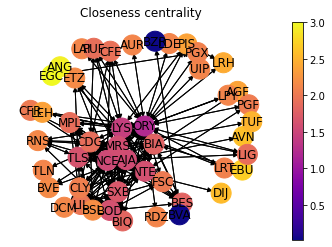

In [20]:
draw(G, pos, closeness_c, 'Closeness centrality')

We conclude that Beauvais Tillé Airport is the farthest and Paris-Orly Airport is the closest to other airports in France.

In [21]:

degrees = {}
for airport in G.nodes():
  degree = utils.degree(G, airport)
  inflow = utils.degree_inflow(G, airport)
  outflow = utils.degree_outflow(G, airport)
  degrees[airport] = [degree, inflow, outflow]

print(degrees, end='\n\n')

max_degree = max(degrees.keys(), key=(lambda k: degrees[k][0]))
min_degree = min(degrees.keys(), key=(lambda k: degrees[k][0]))
print("Max degree: %d %s %s" % (degrees[max_degree][0], max_degree,airport_name_from_iata(filtered_european_airports, max_degree)))
print("Min degree: %d %s %s" % (degrees[min_degree][0], min_degree,airport_name_from_iata(filtered_european_airports, min_degree)))
print("Average degree: ", sum(value[0] for value in degrees.values())/len(degrees.values()))

max_inflow = max(degrees.keys(), key=(lambda k: degrees[k][1]))
min_inflow = min(degrees.keys(), key=(lambda k: degrees[k][1]))
print("Max inflow: %d %s %s" % (degrees[max_inflow][1], max_inflow,airport_name_from_iata(filtered_european_airports, max_inflow)))
print("Min inflow: %d %s %s" % (degrees[min_inflow][1], min_inflow,airport_name_from_iata(filtered_european_airports, min_inflow)))
print("Average inflow: ", sum(value[1] for value in degrees.values())/len(degrees.values()))

max_outflow = max(degrees.keys(), key=(lambda k: degrees[k][2]))
min_outflow = min(degrees.keys(), key=(lambda k: degrees[k][2]))
print("Max outflow: %d %s %s" % (degrees[max_outflow][2], max_outflow,airport_name_from_iata(filtered_european_airports, max_outflow)))
print("Min outflow: %d %s %s" % (degrees[min_outflow][2], min_outflow,airport_name_from_iata(filtered_european_airports, min_outflow)))
print("Average outflow: ", sum(value[2] for value in degrees.values())/len(degrees.values()))


{'AGF': [4, 2, 2], 'DCM': [6, 3, 3], 'ORY': [64, 32, 32], 'AJA': [36, 18, 18], 'BVE': [4, 2, 2], 'PIS': [6, 3, 3], 'AUR': [2, 1, 1], 'BES': [16, 8, 8], 'LYS': [46, 23, 23], 'NCE': [40, 20, 20], 'BIA': [24, 12, 12], 'LIL': [24, 12, 12], 'BIQ': [14, 7, 7], 'BOD': [30, 15, 15], 'NTE': [32, 16, 16], 'SXB': [24, 12, 12], 'CFE': [8, 4, 4], 'CFR': [8, 4, 4], 'CLY': [12, 6, 6], 'ETZ': [8, 4, 4], 'FSC': [14, 7, 7], 'LAI': [2, 1, 1], 'LDE': [2, 1, 1], 'MPL': [16, 8, 8], 'TLS': [28, 14, 14], 'LRH': [4, 2, 2], 'LRT': [4, 2, 2], 'MRS': [36, 18, 18], 'PUF': [8, 4, 4], 'RNS': [12, 6, 6], 'PGF': [4, 2, 2], 'RDZ': [2, 1, 1], 'UIP': [2, 1, 1], 'CDG': [32, 16, 16], 'EBU': [2, 1, 1], 'BSL': [14, 7, 7], 'TLN': [2, 1, 1], 'AVN': [4, 2, 2], 'LIG': [8, 4, 4], 'BVA': [2, 1, 1], 'BZR': [2, 1, 1], 'TUF': [2, 1, 1], 'ANG': [2, 1, 1], 'DIJ': [2, 1, 1], 'EGC': [2, 1, 1], 'PGX': [4, 2, 2], 'LEH': [2, 1, 1], 'LPY': [2, 1, 1]}

Max degree: 64 ORY Paris-Orly Airport
Min degree: 2 AUR Aurillac Airport
Average degree:  1

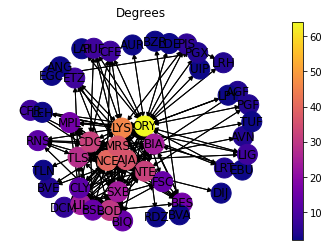

In [22]:
draw(G, pos, dict(nx.degree(G)), 'Degrees')

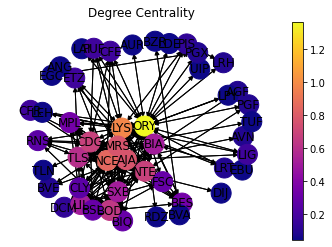

In [23]:
draw(G, pos, dict(nx.degree_centrality(G)), 'Degree Centrality')

Paris-Orly Airport has 5 times more connections than the average airport

In [24]:

#Between Centrality of Airport
between_c = {}
pathes = utils.get_all_pathes(G, 'Distance')

for airport in G.nodes():
  between_c[airport] = utils.between_centrality(G, airport, pathes)

print(between_c)
total_between = sum(value for value in between_c.values())
length_between = len(between_c.values())
max_between = max(between_c.keys(), key=(lambda k: between_c[k]))
min_between = min(between_c.keys(), key=(lambda k: between_c[k]))


print("Max betweenness: %d %s %s | %.2f percent of all pathes" % (between_c[max_between], max_between,airport_name_from_iata(filtered_european_airports, max_between), between_c[max_between]/length_between))
print("Min betweenness: %d %s %s | %.2f percent of all pathes" % (between_c[min_between], min_between,airport_name_from_iata(filtered_european_airports, min_between), between_c[min_between]/length_between))
print("Average betweenness: %.2f" % (total_between/length_between))


{'AGF': 90, 'DCM': 112, 'ORY': 1094, 'AJA': 176, 'BVE': 90, 'PIS': 132, 'AUR': 90, 'BES': 90, 'LYS': 454, 'NCE': 284, 'BIA': 178, 'LIL': 90, 'BIQ': 90, 'BOD': 128, 'NTE': 140, 'SXB': 120, 'CFE': 118, 'CFR': 90, 'CLY': 98, 'ETZ': 90, 'FSC': 178, 'LAI': 90, 'LDE': 90, 'MPL': 90, 'TLS': 178, 'LRH': 126, 'LRT': 90, 'MRS': 236, 'PUF': 90, 'RNS': 90, 'PGF': 90, 'RDZ': 90, 'UIP': 90, 'CDG': 108, 'EBU': 90, 'BSL': 90, 'TLN': 90, 'AVN': 92, 'LIG': 146, 'BVA': 2, 'BZR': 2, 'TUF': 90, 'ANG': 90, 'DIJ': 90, 'EGC': 90, 'PGX': 178, 'LEH': 90, 'LPY': 90}
Max betweenness: 1094 ORY Paris-Orly Airport | 22.79 percent of all pathes
Min betweenness: 2 BVA Paris Beauvais Tillé Airport | 0.04 percent of all pathes
Average betweenness: 137.92


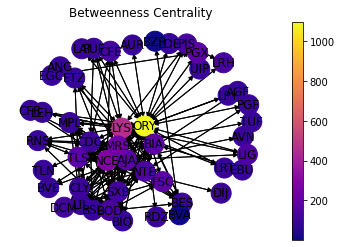

In [25]:
draw(G, pos, between_c, 'Betweenness Centrality')

In [26]:
print("Most important airports:")
print(airport_name_from_iata(filtered_regional_airports, 'ORY'))
print(airport_name_from_iata(filtered_regional_airports,'LYS'))
print(airport_name_from_iata(filtered_regional_airports, 'NCE'))

Most important airports:
Paris-Orly Airport
Lyon Saint-Exupéry Airport
Nice-Côte d'Azur Airport


As we can see the Paris-Orly Airport is the most common intermediate airport, it was occured in 1094 pathes which makes up 23% of all pathes.
Meanwhile Paris Beauvasi Tille Airport only occurs in 2 pathes.


In [27]:
# shortest pathes were used inside previous functions like closeness centrality
# here is an example of Dijkstra's shortest path

print('From %s -> %s : ' % ('EGC', 'EBU'), shortest_path.dijkstra(G, 'EGC', 'EBU', 'Distance'))
print('From %s -> %s : ' % ('LRH', 'PGF'), shortest_path.dijkstra(G, 'LRH', 'PGF', 'Distance'))


From EGC -> EBU :  ['EGC', 'PGX', 'ORY', 'BIA', 'EBU']
From LRH -> PGF :  ['LRH', 'ORY', 'PGF']
